# Regression modeling with Traffic + Population + Weather Data

In [1]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import pprint
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from math import sqrt
from sklearn import ensemble
from sklearn.inspection import permutation_importance

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score
import xgboost as xgb
%matplotlib inline


In [2]:
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', '{:.2f}'.format)
np.set_printoptions(suppress=True)

In [3]:
df = pd.read_csv("./data/hourly/trfc_wthr_cnss.csv")

In [4]:
df.head()

,ZipCode,StartTime(UTC),Severity,LocationLat,LocationLng,Duration,irs_estimated_population_2015,Population Estimate (as of July 1) - 2018 - Both Sexes; Median age (years),Population Estimate (as of July 1) - 2018 - Male; Median age (years),Population Estimate (as of July 1) - 2018 - Female; Median age (years),wthr_Duration,TypeEncoded,SeveEncoded
0,98001,2016-08-02 01:00:00,2.00,47.30,-122.23,29.00,31710.00,36.90,36.20,37.70,-1.00,-1.00,-1.00
1,98001,2016-08-02 17:00:00,1.00,47.33,-122.29,14.00,31710.00,36.90,36.20,37.70,-1.00,-1.00,-1.00
2,98001,2016-08-03 01:00:00,2.00,47.28,-122.26,13.00,31710.00,36.90,36.20,37.70,-1.00,-1.00,-1.00
3,98001,2016-08-03 16:00:00,2.00,47.35,-122.25,56.00,31710.00,36.90,36.20,37.70,-1.00,-1.00,-1.00
4,98001,2016-08-03 17:00:00,1.00,47.35,-122.29,11.00,31710.00,36.90,36.20,37.70,-1.00,-1.00,-1.00


In [5]:
df_prune = df.copy()

In [6]:
df_prune.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347330 entries, 0 to 347329
Data columns (total 13 columns):
 #   Column                                                                      Non-Null Count   Dtype  
---  ------                                                                      --------------   -----  
 0   ZipCode                                                                     347330 non-null  int64  
 1   StartTime(UTC)                                                              347330 non-null  object 
 2   Severity                                                                    347330 non-null  float64
 3   LocationLat                                                                 347330 non-null  float64
 4   LocationLng                                                                 347330 non-null  float64
 5   Duration                                                                    347330 non-null  float64
 6   irs_estimated_population_2015       

In [7]:
def Mon(x):
    return x.split(" ")[0].split('-')[1]
def Day(x):
    return x.split(" ")[0].split('-')[2]
def Hour(x):
    return x.split(" ")[1].split(':')[0]
def Minute(x):
    return x.split(" ")[1].split(':')[1]

In [8]:
df_prune['StartMonth'] = df_prune['StartTime(UTC)'].apply(lambda x: Mon(x)).astype(int)
df_prune['StartDay'] = df_prune['StartTime(UTC)'].apply(lambda x: Day(x)).astype(int)
df_prune['StartHour'] = df_prune['StartTime(UTC)'].apply(lambda x: Hour(x)).astype(int)
df_prune['StartMinute'] = df_prune['StartTime(UTC)'].apply(lambda x: Minute(x)).astype(int)

In [9]:
df_prune.drop('StartTime(UTC)', inplace=True, axis = 1)

In [10]:
df_prune.isnull().sum().sum()

0

In [11]:
len(df_prune)

347330

In [12]:
df_prune.dropna(inplace=True)

In [14]:
df_prune.head()

,ZipCode,Severity,LocationLat,LocationLng,Duration,irs_estimated_population_2015,Population Estimate (as of July 1) - 2018 - Both Sexes; Median age (years),Population Estimate (as of July 1) - 2018 - Male; Median age (years),Population Estimate (as of July 1) - 2018 - Female; Median age (years),wthr_Duration,TypeEncoded,SeveEncoded,StartMonth,StartDay,StartHour,StartMinute
0,98001,2.00,47.30,-122.23,29.00,31710.00,36.90,36.20,37.70,-1.00,-1.00,-1.00,8,2,1,0
1,98001,1.00,47.33,-122.29,14.00,31710.00,36.90,36.20,37.70,-1.00,-1.00,-1.00,8,2,17,0
2,98001,2.00,47.28,-122.26,13.00,31710.00,36.90,36.20,37.70,-1.00,-1.00,-1.00,8,3,1,0
3,98001,2.00,47.35,-122.25,56.00,31710.00,36.90,36.20,37.70,-1.00,-1.00,-1.00,8,3,16,0
4,98001,1.00,47.35,-122.29,11.00,31710.00,36.90,36.20,37.70,-1.00,-1.00,-1.00,8,3,17,0


In [15]:
def RSquare(df, col):
    X, y = df.drop(col,axis=1), df[col]

    X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10) #hold out 20% of the data for final testing

    #this helps with the way kf will generate indices below
    X, y = np.array(X), np.array(y)
    
    kf = KFold(n_splits=5, shuffle=True, random_state = 50)
    cv_lm_r2s, cv_lm_reg_r2s, cv_lm_poly_r2s, cv_lasso_r2s = [], [], [], [] #collect the validation results for both models

    for train_ind, val_ind in kf.split(X,y):

        X_train, y_train = X[train_ind], y[train_ind]
        X_val, y_val = X[val_ind], y[val_ind] 

        #simple linear regression
        lm = LinearRegression()
        lm_reg = Ridge(alpha=1)
        lm_poly = LinearRegression()

        lm.fit(X_train, y_train)
        cv_lm_r2s.append(lm.score(X_val, y_val))
#         cv_lm_r2s.append(lm.score(X_tra, y_tra))

        #ridge with feature scaling
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        lm_reg.fit(X_train_scaled, y_train)
        cv_lm_reg_r2s.append(lm_reg.score(X_val_scaled, y_val))

        poly = PolynomialFeatures(degree=2) 
        X_train_poly = poly.fit_transform(X_train)
        X_val_poly = poly.fit_transform(X_val)
        lm_poly.fit(X_train_poly, y_train)
        cv_lm_poly_r2s.append(lm_poly.score(X_val_poly, y_val))
        
        #Lasso
        std = StandardScaler()
        std.fit(X_train)
        
        X_tr = std.transform(X_train)
        X_te = std.transform(X_test)
        
        X_val_lasso = std.transform(X_val)
        
        alphavec = 10**np.linspace(-10,10,1000)

        lasso_model = LassoCV(alphas = alphavec, cv=5)
        lasso_model.fit(X_tr, y_train)
        cv_lasso_r2s.append(lasso_model.score(X_val_lasso, y_val))
        
        test_set_pred = lasso_model.predict(X_te)
        
        column = df.drop(col,axis=1)
        to_print = list(zip(column.columns, lasso_model.coef_))
        pp = pprint.PrettyPrinter(indent = 1)
    
        rms = sqrt(mean_squared_error(y_test, test_set_pred))
        
    print('Simple regression scores: ', cv_lm_r2s, '\n')
    print('Ridge scores: ', cv_lm_reg_r2s, '\n')
    print('Poly scores: ', cv_lm_poly_r2s, '\n')
    print('Lasso scores: ', cv_lasso_r2s, '\n')

    print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')
    print(f'Ridge mean cv r^2: {np.mean(cv_lm_reg_r2s):.3f} +- {np.std(cv_lm_reg_r2s):.3f}')
    print(f'Poly mean cv r^2: {np.mean(cv_lm_poly_r2s):.3f} +- {np.std(cv_lm_poly_r2s):.3f}', '\n')
    
    print('lasso_model.alpha_:', lasso_model.alpha_)
    print(f'Lasso cv r^2: {r2_score(y_test, test_set_pred):.3f} +- {np.std(cv_lasso_r2s):.3f}', '\n')
    
    print(f'MAE: {mae(y_test, test_set_pred)}', '\n')
    print('RMSE:', rms, '\n')
    mse = mean_squared_error(y_test, test_set_pred)
    print('MSE:', mse, '\n')
    
    print('Lasso Coef:')
    pp.pprint (to_print)

In [16]:
# 'Mean absolute error'
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

In [17]:
RSquare(df_prune, 'Duration')

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 141266.50527912378, tolerance: 29887.709438205595
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 733968.7207112014, tolerance: 29887.709438205595
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1532562.0496335924, tolerance: 29887.709438205595
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Du

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9373174.52478832, tolerance: 29887.709438205595
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9373237.087250292, tolerance: 29887.709438205595
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9373290.364698708, tolerance: 29887.709438205595
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duali

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9373566.603336751, tolerance: 29887.709438205595
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9373566.295459986, tolerance: 29887.709438205595
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9373566.046275169, tolerance: 29887.709438205595
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dual

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9373572.718167603, tolerance: 29887.709438205595
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9373562.965729296, tolerance: 29887.709438205595
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9373543.502978295, tolerance: 29887.709438205595
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dual

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9373339.573070496, tolerance: 29887.709438205595
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9373740.901750982, tolerance: 29887.709438205595
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9373616.209869891, tolerance: 29887.709438205595
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dual

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9376438.978500843, tolerance: 29887.709438205595
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9372608.322505653, tolerance: 29887.709438205595
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9380743.00133264, tolerance: 29887.709438205595
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duali

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78865318.86840355, tolerance: 94305.20134060083
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79251979.95122087, tolerance: 94305.20134060083
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79583145.73947442, tolerance: 94305.20134060083
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81565857.10435832, tolerance: 94305.20134060083
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81565877.25213623, tolerance: 94305.20134060083
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81565893.39837039, tolerance: 94305.20134060083
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81565960.11271632, tolerance: 94305.20134060083
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81565975.26626599, tolerance: 94305.20134060083
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81565955.321082, tolerance: 94305.20134060083
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality g

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81566204.3809191, tolerance: 94305.20134060083
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81566463.02154696, tolerance: 94305.20134060083
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81566821.03028798, tolerance: 94305.20134060083
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality 

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81556964.77998877, tolerance: 94305.20134060083
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81554733.68342113, tolerance: 94305.20134060083
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81519827.29414189, tolerance: 94305.20134060083
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30707632.0495373, tolerance: 94597.84846312947
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30707923.66202414, tolerance: 94597.84846312947
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30708173.137816787, tolerance: 94597.84846312947
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81595699.85073459, tolerance: 94597.84846312947
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81598041.43600261, tolerance: 94597.84846312947
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81600047.92798066, tolerance: 94597.84846312947
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81612067.36996484, tolerance: 94597.84846312947
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81612070.89326012, tolerance: 94597.84846312947
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81612064.35850847, tolerance: 94597.84846312947
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81612471.03967714, tolerance: 94597.84846312947
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81611561.88604188, tolerance: 94597.84846312947
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81611916.65278637, tolerance: 94597.84846312947
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81618922.83382297, tolerance: 94597.84846312947
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81623369.38808763, tolerance: 94597.84846312947
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81616995.36460698, tolerance: 94597.84846312947
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 805110.5307891369, tolerance: 94170.75384929514
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2942133.347694516, tolerance: 94170.75384929514
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5596727.629992247, tolerance: 94170.75384929514
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79965560.01222241, tolerance: 94170.75384929514
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80045217.66458249, tolerance: 94170.75384929514
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80113392.85347259, tolerance: 94170.75384929514
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80518344.33173287, tolerance: 94170.75384929514
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80518344.73552871, tolerance: 94170.75384929514
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80518349.71770191, tolerance: 94170.75384929514
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80518335.69374359, tolerance: 94170.75384929514
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80518316.34133792, tolerance: 94170.75384929514
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80518330.45955467, tolerance: 94170.75384929514
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80518442.49027061, tolerance: 94170.75384929514
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80517655.19688678, tolerance: 94170.75384929514
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80518911.05073547, tolerance: 94170.75384929514
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80537116.99062169, tolerance: 94170.75384929514
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80520058.05595064, tolerance: 94170.75384929514
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80507813.74277604, tolerance: 94170.75384929514
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 148725.31083798409, tolerance: 89512.02024151373
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1654302.0913301706, tolerance: 89512.02024151373
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3986939.7351806164, tolerance: 89512.02024151373
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dual

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76168371.25569844, tolerance: 89512.02024151373
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76190409.56418669, tolerance: 89512.02024151373
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76209268.16128582, tolerance: 89512.02024151373
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76320984.68271506, tolerance: 89512.02024151373
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76320980.40209407, tolerance: 89512.02024151373
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76320979.09523743, tolerance: 89512.02024151373
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76320953.2310574, tolerance: 89512.02024151373
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76320965.04034233, tolerance: 89512.02024151373
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76320917.08908576, tolerance: 89512.02024151373
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality 

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76320862.35923266, tolerance: 89512.02024151373
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76321060.2647239, tolerance: 89512.02024151373
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76321656.95452422, tolerance: 89512.02024151373
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality 

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76315679.09788239, tolerance: 89512.02024151373
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76315618.88956404, tolerance: 89512.02024151373
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76325198.26516473, tolerance: 89512.02024151373
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 259246234.32705534, tolerance: 100618.41291263654
  positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 346937.51326301694, tolerance: 24689.46038517207
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 942850.3260688186, tolerance: 24689.46038517207
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1627793.5

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5492322.466168523, tolerance: 24689.46038517207
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7514572.665304482, tolerance: 24689.46038517207
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9321121.425888538, tolerance: 24689.46038517207
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20222310.15419334, tolerance: 24689.46038517207
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20222420.647958755, tolerance: 24689.46038517207
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20222514.76799044, tolerance: 24689.46038517207
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dualit

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20223069.262547493, tolerance: 24689.46038517207
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20223074.811496437, tolerance: 24689.46038517207
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20223051.296927392, tolerance: 24689.46038517207
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dual

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20223235.78638962, tolerance: 24689.46038517207
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20223154.802987337, tolerance: 24689.46038517207
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20222993.18507448, tolerance: 24689.46038517207
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dualit

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20222800.17558956, tolerance: 24689.46038517207
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20225352.584882677, tolerance: 24689.46038517207
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20225856.5387789, tolerance: 24689.46038517207
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 89281.82113707066, tolerance: 88970.12122308047
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1480141.290784955, tolerance: 88970.12122308047
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3764230.4996734858, tolerance: 88970.12122308047
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dualit

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75994641.13699836, tolerance: 88970.12122308047
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76033937.83297008, tolerance: 88970.12122308047
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76067586.73734516, tolerance: 88970.12122308047
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76267927.29817069, tolerance: 88970.12122308047
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76267937.96810907, tolerance: 88970.12122308047
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76267946.47572803, tolerance: 88970.12122308047
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76267960.56304204, tolerance: 88970.12122308047
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76267978.9529739, tolerance: 88970.12122308047
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76267969.07513434, tolerance: 88970.12122308047
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality 

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76267973.58758175, tolerance: 88970.12122308047
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76268076.39344597, tolerance: 88970.12122308047
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76267802.46668392, tolerance: 88970.12122308047
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76260531.75246304, tolerance: 88970.12122308047
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76269838.00683087, tolerance: 88970.12122308047
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76263144.32526767, tolerance: 88970.12122308047
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 983705.5210620165, tolerance: 89406.01770580516
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3108847.703042507, tolerance: 89406.01770580516
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5652151.675829887, tolerance: 89406.01770580516
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75743692.88975191, tolerance: 89406.01770580516
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75782235.76871037, tolerance: 89406.01770580516
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75815205.12311286, tolerance: 89406.01770580516
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76010182.4038645, tolerance: 89406.01770580516
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76010182.35438657, tolerance: 89406.01770580516
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76010181.5269131, tolerance: 89406.01770580516
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality g

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76010193.45154542, tolerance: 89406.01770580516
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76010211.17617029, tolerance: 89406.01770580516
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76010200.10891789, tolerance: 89406.01770580516
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76011154.3793568, tolerance: 89406.01770580516
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76011116.56971407, tolerance: 89406.01770580516
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76010081.30905974, tolerance: 89406.01770580516
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality 

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76023673.29352963, tolerance: 89406.01770580516
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75994345.06465733, tolerance: 89406.01770580516
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75997562.8043207, tolerance: 89406.01770580516
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality 

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 604054.6623750925, tolerance: 89149.06602021189
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2524926.674320698, tolerance: 89149.06602021189
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4982161.523120642, tolerance: 89149.06602021189
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74375501.31532592, tolerance: 89149.06602021189
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74388640.57943183, tolerance: 89149.06602021189
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74399855.41406447, tolerance: 89149.06602021189
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74465083.95245957, tolerance: 89149.06602021189
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74465084.8122915, tolerance: 89149.06602021189
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74465086.20249295, tolerance: 89149.06602021189
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality 

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74465087.89378667, tolerance: 89149.06602021189
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74465059.80703574, tolerance: 89149.06602021189
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74465077.60211945, tolerance: 89149.06602021189
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74464846.26257539, tolerance: 89149.06602021189
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74465723.79522806, tolerance: 89149.06602021189
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74465878.17590714, tolerance: 89149.06602021189
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74472955.70231175, tolerance: 89149.06602021189
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74482646.61113387, tolerance: 89149.06602021189
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74450988.12300467, tolerance: 89149.06602021189
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 375572.622027874, tolerance: 89195.84905616514
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2137411.0606968403, tolerance: 89195.84905616514
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4553956.2386443615, tolerance: 89195.84905616514
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dualit

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75472144.40027916, tolerance: 89195.84905616514
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75497493.1268605, tolerance: 89195.84905616514
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75519170.02754343, tolerance: 89195.84905616514
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality 

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75647032.32662833, tolerance: 89195.84905616514
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75647031.3148002, tolerance: 89195.84905616514
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75647028.6765737, tolerance: 89195.84905616514
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality g

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75647017.2886675, tolerance: 89195.84905616514
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75647050.38084579, tolerance: 89195.84905616514
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75647038.69478619, tolerance: 89195.84905616514
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality 

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75646812.1787073, tolerance: 89195.84905616514
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75646491.99573344, tolerance: 89195.84905616514
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75647584.08841544, tolerance: 89195.84905616514
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality 

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75636178.35772437, tolerance: 89195.84905616514
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75633150.59673804, tolerance: 89195.84905616514
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75665913.68641871, tolerance: 89195.84905616514
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 377674124.32983804, tolerance: 95352.68208995163
  positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 67022.37595623732, tolerance: 29103.419524682577
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 573355.5538511276, tolerance: 29103.419524682577
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1324850.8

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9114293.655996203, tolerance: 29103.419524682577
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9114346.91745171, tolerance: 29103.419524682577
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9114392.206369668, tolerance: 29103.419524682577
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duali

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9114623.272441834, tolerance: 29103.419524682577
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9114623.124657214, tolerance: 29103.419524682577
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9114622.834958702, tolerance: 29103.419524682577
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dual

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9114609.060378581, tolerance: 29103.419524682577
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9114601.200411767, tolerance: 29103.419524682577
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9114616.438486814, tolerance: 29103.419524682577
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dual

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9114713.20502004, tolerance: 29103.419524682577
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9114474.465768188, tolerance: 29103.419524682577
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9114875.77519694, tolerance: 29103.419524682577
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dualit

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9116770.608347863, tolerance: 29103.419524682577
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9108315.504833281, tolerance: 29103.419524682577
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9121531.745682895, tolerance: 29103.419524682577
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dual

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14598271.484222949, tolerance: 45629.89399860074
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14598342.6298064, tolerance: 45629.89399860074
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14598403.37664932, tolerance: 45629.89399860074
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14598715.88028115, tolerance: 45629.89399860074
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14598714.942344904, tolerance: 45629.89399860074
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14598715.986204028, tolerance: 45629.89399860074
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duali

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14598702.587061405, tolerance: 45629.89399860074
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14598688.701310813, tolerance: 45629.89399860074
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14598707.132878542, tolerance: 45629.89399860074
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dual

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14598399.424227357, tolerance: 45629.89399860074
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14598997.312882066, tolerance: 45629.89399860074
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14599021.838357747, tolerance: 45629.89399860074
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dual

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14595550.148108363, tolerance: 45629.89399860074
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14608305.321703732, tolerance: 45629.89399860074
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14601814.660717607, tolerance: 45629.89399860074
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dual

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14470281.70739305, tolerance: 45965.02305770879
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14470333.274510086, tolerance: 45965.02305770879
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14470377.164799094, tolerance: 45965.02305770879
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duali

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14470603.035750926, tolerance: 45965.02305770879
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14470602.806307197, tolerance: 45965.02305770879
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14470602.065930903, tolerance: 45965.02305770879
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dual

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14470607.716116786, tolerance: 45965.02305770879
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14470591.676630914, tolerance: 45965.02305770879
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14470624.97099495, tolerance: 45965.02305770879
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duali

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14469942.517210603, tolerance: 45965.02305770879
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14470794.12629807, tolerance: 45965.02305770879
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14470577.840780675, tolerance: 45965.02305770879
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duali

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14475427.367613196, tolerance: 45965.02305770879
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14475723.692932189, tolerance: 45965.02305770879
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14463104.639943957, tolerance: 45965.02305770879
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dual

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14267467.872744381, tolerance: 45787.60854504847
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14267592.29071188, tolerance: 45787.60854504847
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14267698.150599062, tolerance: 45787.60854504847
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duali

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38151952.453564465, tolerance: 45787.60854504847
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38154211.759424776, tolerance: 45787.60854504847
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38156143.78728855, tolerance: 45787.60854504847
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duali

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38167503.98840433, tolerance: 45787.60854504847
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38167511.79687226, tolerance: 45787.60854504847
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38167496.37480551, tolerance: 45787.60854504847
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38167015.04085636, tolerance: 45787.60854504847
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38167945.08166316, tolerance: 45787.60854504847
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38166872.25506067, tolerance: 45787.60854504847
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38166381.54110739, tolerance: 45787.60854504847
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38169998.97436023, tolerance: 45787.60854504847
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38157795.03534877, tolerance: 45787.60854504847
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32108090.142206997, tolerance: 40960.44550030321
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32505760.598590225, tolerance: 40960.44550030321
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32846025.907735974, tolerance: 40960.44550030321
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dual

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34877340.82432997, tolerance: 40960.44550030321
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34877352.34740284, tolerance: 40960.44550030321
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34877365.26605469, tolerance: 40960.44550030321
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34877431.6252622, tolerance: 40960.44550030321
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34877436.023252785, tolerance: 40960.44550030321
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34877422.92544308, tolerance: 40960.44550030321
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34876866.1305545, tolerance: 40960.44550030321
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34877660.10776788, tolerance: 40960.44550030321
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34877006.13706511, tolerance: 40960.44550030321
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality 

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34876929.45879936, tolerance: 40960.44550030321
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34877434.11620706, tolerance: 40960.44550030321
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34884067.85238591, tolerance: 40960.44550030321
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9114271.457479715, tolerance: 29794.11796596535
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9114374.536473036, tolerance: 29794.11796596535
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9114462.383512586, tolerance: 29794.11796596535
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9114949.598911583, tolerance: 29794.11796596535
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9114947.791412741, tolerance: 29794.11796596535
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9114948.650773138, tolerance: 29794.11796596535
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9114935.744134545, tolerance: 29794.11796596535
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9114953.823726356, tolerance: 29794.11796596535
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9114935.233079404, tolerance: 29794.11796596535
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9115011.25534141, tolerance: 29794.11796596535
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9115128.779888272, tolerance: 29794.11796596535
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9114941.32613337, tolerance: 29794.11796596535
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality g

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9116792.245910972, tolerance: 29794.11796596535
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9116068.308260292, tolerance: 29794.11796596535
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9120162.745204836, tolerance: 29794.11796596535
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30186248.997422934, tolerance: 94104.35036550194
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30186536.10884714, tolerance: 94104.35036550194
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30186781.35506475, tolerance: 94104.35036550194
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dualit

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80174182.01987922, tolerance: 94104.35036550194
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80208726.9151721, tolerance: 94104.35036550194
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80238297.8879956, tolerance: 94104.35036550194
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality g

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80413960.30099535, tolerance: 94104.35036550194
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80413935.45242548, tolerance: 94104.35036550194
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80413970.50746822, tolerance: 94104.35036550194
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80413962.7475996, tolerance: 94104.35036550194
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80414060.57214665, tolerance: 94104.35036550194
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80414049.1662345, tolerance: 94104.35036550194
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality g

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80415399.85208476, tolerance: 94104.35036550194
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80411465.74406064, tolerance: 94104.35036550194
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80412602.49612617, tolerance: 94104.35036550194
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 206439.78264677525, tolerance: 94535.08841908831
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1873329.0634032488, tolerance: 94535.08841908831
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4370535.009837985, tolerance: 94535.08841908831
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duali

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30225890.41168058, tolerance: 94535.08841908831
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30226130.29910636, tolerance: 94535.08841908831
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30226335.154548764, tolerance: 94535.08841908831
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dualit

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30227504.36134565, tolerance: 94535.08841908831
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30227505.70041859, tolerance: 94535.08841908831
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30227506.630599737, tolerance: 94535.08841908831
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dualit

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30227505.23176849, tolerance: 94535.08841908831
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30227524.264991403, tolerance: 94535.08841908831
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30227510.243066072, tolerance: 94535.08841908831
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duali

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30227790.6708591, tolerance: 94535.08841908831
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30227284.849526048, tolerance: 94535.08841908831
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30228389.596214294, tolerance: 94535.08841908831
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dualit

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30219061.48080933, tolerance: 94535.08841908831
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30216762.417453527, tolerance: 94535.08841908831
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30217979.939268947, tolerance: 94535.08841908831
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duali

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75565576.33744967, tolerance: 94194.6126119275
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76136794.03370214, tolerance: 94194.6126119275
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76624364.77378094, tolerance: 94194.6126119275
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality ga

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79478768.0506934, tolerance: 94194.6126119275
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79478801.4245398, tolerance: 94194.6126119275
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79478829.31449795, tolerance: 94194.6126119275
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap:

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79478951.92748284, tolerance: 94194.6126119275
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79478997.07096124, tolerance: 94194.6126119275
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79478993.01783288, tolerance: 94194.6126119275
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality ga

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79478929.658674, tolerance: 94194.6126119275
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79478740.55286062, tolerance: 94194.6126119275
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79478267.18170154, tolerance: 94194.6126119275
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap:

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79483563.3998189, tolerance: 94194.6126119275
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79471031.79265845, tolerance: 94194.6126119275
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79484764.96559584, tolerance: 94194.6126119275
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 375664.3427337408, tolerance: 89609.55525236674
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2147414.267881751, tolerance: 89609.55525236674
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4581563.005920649, tolerance: 89609.55525236674
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75784739.77475274, tolerance: 89609.55525236674
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75879574.86879718, tolerance: 89609.55525236674
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75960723.59896821, tolerance: 89609.55525236674
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76442192.87223846, tolerance: 89609.55525236674
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76442195.16860282, tolerance: 89609.55525236674
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76442196.04848695, tolerance: 89609.55525236674
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76442206.89764184, tolerance: 89609.55525236674
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76442204.52480054, tolerance: 89609.55525236674
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76442233.89775264, tolerance: 89609.55525236674
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76442750.17381835, tolerance: 89609.55525236674
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76441252.00492609, tolerance: 89609.55525236674
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76441288.48068291, tolerance: 89609.55525236674
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76467813.86979407, tolerance: 89609.55525236674
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76456378.21777773, tolerance: 89609.55525236674
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76409890.05581951, tolerance: 89609.55525236674
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 477154.1437638998, tolerance: 29415.904312424078
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1209497.8375733495, tolerance: 29415.904312424078
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2035325.2220349014, tolerance: 29415.904312424078
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Du

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9101483.955497533, tolerance: 29415.904312424078
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9101529.45490992, tolerance: 29415.904312424078
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9101568.264872372, tolerance: 29415.904312424078
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duali

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9101791.144511938, tolerance: 29415.904312424078
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9101789.27727738, tolerance: 29415.904312424078
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9101790.958357304, tolerance: 29415.904312424078
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duali

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9101790.431537032, tolerance: 29415.904312424078
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9101745.861367434, tolerance: 29415.904312424078
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9101781.018940866, tolerance: 29415.904312424078
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dual

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9102890.145864874, tolerance: 29415.904312424078
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9102533.544423401, tolerance: 29415.904312424078
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9102514.45322749, tolerance: 29415.904312424078
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duali

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 188488.40564250946, tolerance: 76898.8931703308
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1570711.8701540232, tolerance: 76898.8931703308
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3614512.1711746454, tolerance: 76898.8931703308
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24884551.052766204, tolerance: 76898.8931703308
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24884765.446791053, tolerance: 76898.8931703308
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24884948.783759236, tolerance: 76898.8931703308
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24886000.089841843, tolerance: 76898.8931703308
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24885999.28546226, tolerance: 76898.8931703308
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24885999.58775139, tolerance: 76898.8931703308
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality g

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24885991.282405615, tolerance: 76898.8931703308
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24885992.75576961, tolerance: 76898.8931703308
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24886012.74324763, tolerance: 76898.8931703308
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality g

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24885907.91145134, tolerance: 76898.8931703308
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24886364.05954039, tolerance: 76898.8931703308
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24886010.062314272, tolerance: 76898.8931703308
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality g

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24879618.458307862, tolerance: 76898.8931703308
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24886424.77375543, tolerance: 76898.8931703308
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24893825.628135204, tolerance: 76898.8931703308
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality 

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1282060.2996186018, tolerance: 77230.54815822812
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3260101.424461007, tolerance: 77230.54815822812
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5494083.415739298, tolerance: 77230.54815822812
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dualit

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24726962.676027298, tolerance: 77230.54815822812
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24727167.984962106, tolerance: 77230.54815822812
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24727343.597672462, tolerance: 77230.54815822812
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dual

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24728350.914123416, tolerance: 77230.54815822812
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24728349.778330922, tolerance: 77230.54815822812
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24728350.075743318, tolerance: 77230.54815822812
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dual

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24728312.44634247, tolerance: 77230.54815822812
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24728365.438132644, tolerance: 77230.54815822812
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24728376.377318144, tolerance: 77230.54815822812
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duali

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24727702.42394364, tolerance: 77230.54815822812
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24727976.77676809, tolerance: 77230.54815822812
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24727439.933909297, tolerance: 77230.54815822812
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dualit

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24731060.50830221, tolerance: 77230.54815822812
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24737779.72528577, tolerance: 77230.54815822812
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24722854.184761167, tolerance: 77230.54815822812
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dualit

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24452485.723952413, tolerance: 76785.04826928562
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24452748.11544621, tolerance: 76785.04826928562
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24452972.12371719, tolerance: 76785.04826928562
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dualit

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24454244.685275197, tolerance: 76785.04826928562
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24454243.815631628, tolerance: 76785.04826928562
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24454245.145601273, tolerance: 76785.04826928562
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dual

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24454229.34936893, tolerance: 76785.04826928562
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24454246.466873765, tolerance: 76785.04826928562
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24454255.19124341, tolerance: 76785.04826928562
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dualit

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24453562.39664328, tolerance: 76785.04826928562
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24454856.5840261, tolerance: 76785.04826928562
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24454078.940053463, tolerance: 76785.04826928562
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24440367.220390797, tolerance: 76785.04826928562
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24458203.34953165, tolerance: 76785.04826928562
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24445604.08384204, tolerance: 76785.04826928562
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dualit

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22997128.34818524, tolerance: 72271.58805431813
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22997262.98397845, tolerance: 72271.58805431813
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22997377.83121562, tolerance: 72271.58805431813
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22997999.300174832, tolerance: 72271.58805431813
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18600902.894639492, tolerance: 72271.58805431813
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3345381.7255495787, tolerance: 72271.58805431813
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dual

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61419277.56583756, tolerance: 72271.58805431813
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61419822.46448958, tolerance: 72271.58805431813
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61420329.96531612, tolerance: 72271.58805431813
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61423240.87025881, tolerance: 72271.58805431813
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61422590.5734635, tolerance: 72271.58805431813
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61422818.346126735, tolerance: 72271.58805431813
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61409602.23585951, tolerance: 72271.58805431813
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61433932.465254724, tolerance: 72271.58805431813
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 61433524.80532646, tolerance: 72271.58805431813
  tol, rng, random, positive)
F:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dualit

Simple regression scores:  [0.048921225074718966, 0.028216883357478295, 0.006085763847746728, 0.0481276774602748, 0.015423512350103752] 

Ridge scores:  [0.0489224552903631, 0.02822018000454085, 0.0060856340555573984, 0.048126833929625135, 0.015423057710488797] 

Poly scores:  [0.07155188369709065, 0.04194044283118126, 0.008984200177530322, 0.06931500450285488, 0.0233512148876025] 

Lasso scores:  [0.04893180596571689, 0.028258987575133787, 0.006083956592286777, 0.04810231507360507, 0.015415028308093937] 

Simple mean cv r^2: 0.029 +- 0.017
Ridge mean cv r^2: 0.029 +- 0.017
Poly mean cv r^2: 0.043 +- 0.025 

lasso_model.alpha_: 0.0021248453524988827
Lasso cv r^2: 0.006 +- 0.017 

MAE: 20.798720499563036 

RMSE: 101.91324111454794 

MSE: 10386.308714471985 

Lasso Coef:
[('ZipCode', -2.414641651070269),
 ('Severity', 2.3773996772965718),
 ('LocationLat', -1.0658211325091762),
 ('LocationLng', -1.136855779477747),
 ('irs_estimated_population_2015', -1.1312126729360066),
 ('Population Est

## Split dataset

In [75]:
X, y = df_prune.drop('Duration',axis=1), df_prune['Duration']
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.1, random_state=13)

In [76]:
def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

In [77]:
train, validate, test = train_validate_test_split(df_prune)
X_train, y_train = train.drop('Duration',axis=1), train['Duration']
X_validate, y_validate = validate.drop('Duration',axis=1), validate['Duration']
X_test, y_test = test.drop('Duration',axis=1), test['Duration']

## Gradient Boosting

In [66]:
params = {'n_estimators': 1000,
          'max_depth': 5,
          'min_samples_split': 10,
          'learning_rate': 0.01,
          'loss': 'ls'}

In [67]:
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

mse = mean_squared_error(y_validate, reg.predict(X_validate))
r2 = r2_score(y_validate, reg.predict(X_validate))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print("The R^2 on test set: {:.4f}".format(r2))

The mean squared error (MSE) on test set: 11769.3095
The R^2 on test set: -0.0111


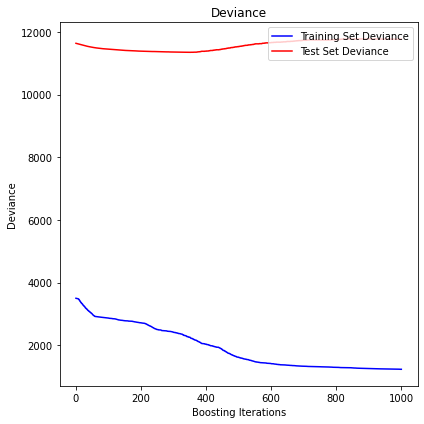

In [68]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_validate)):
    test_score[i] = reg.loss_(y_validate, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, reg.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Validation Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()

In [78]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor

In [105]:
est = HistGradientBoostingRegressor(max_iter =100, 
                                    min_samples_leaf = 720, 
                                    max_leaf_nodes =600, 
                                    l2_regularization = 0, 
                                    learning_rate= 0.1,
                                    verbose=0,
                                    random_state=42).fit(X_train, y_train)
est.score(X_validate, y_validate)

0.1660076147949402

In [88]:
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer

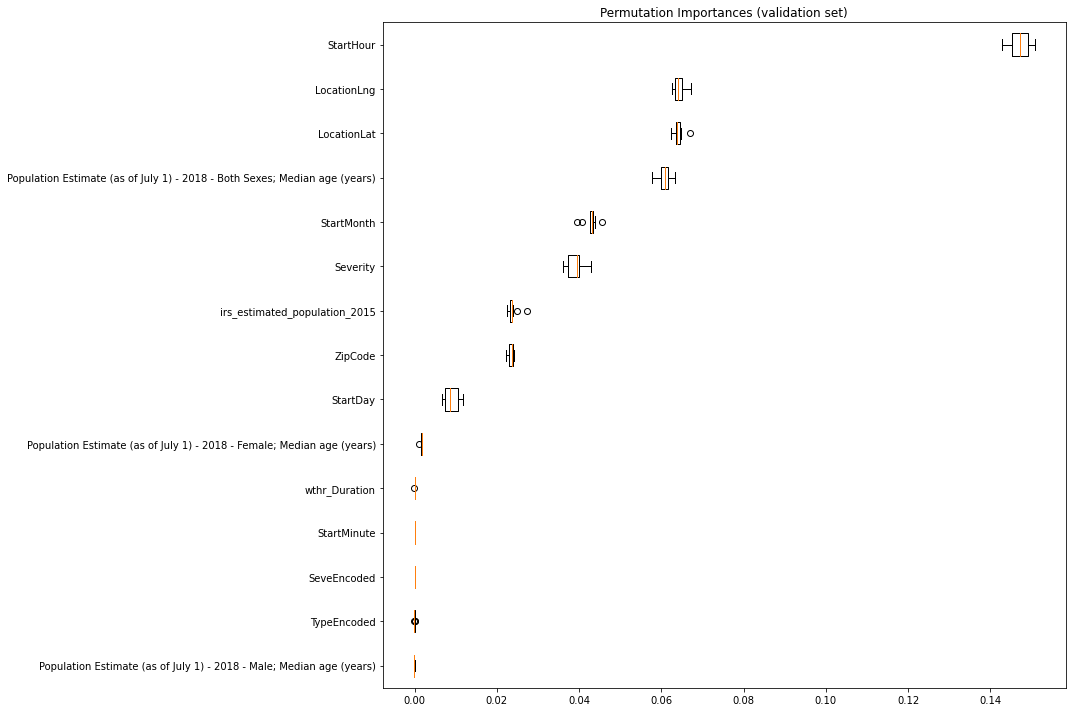

In [89]:
result = permutation_importance(est, X_validate, y_validate, n_repeats=10,
                                random_state=42, n_jobs=1)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(15, 10))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (validation set)")
fig.tight_layout()
plt.show()

In [90]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(est, random_state=1).fit(X_validate, y_validate)
eli5.show_weights(perm, feature_names = X_validate.columns.tolist())

Weight,Feature
0.1485 ± 0.0025,StartHour
0.0641 ± 0.0026,LocationLat
0.0638 ± 0.0006,LocationLng
0.0598 ± 0.0041,Population Estimate (as of July 1) - 2018 - Both Sexes; Median age (years)
0.0417 ± 0.0034,StartMonth
0.0403 ± 0.0023,Severity
0.0246 ± 0.0012,irs_estimated_population_2015
0.0240 ± 0.0010,ZipCode
0.0078 ± 0.0047,StartDay
0.0017 ± 0.0006,Population Estimate (as of July 1) - 2018 - Female; Median age (years)


In [71]:
X_test

,ZipCode,Severity,LocationLat,LocationLng,irs_estimated_population_2015,Population Estimate (as of July 1) - 2018 - Both Sexes; Median age (years),Population Estimate (as of July 1) - 2018 - Male; Median age (years),Population Estimate (as of July 1) - 2018 - Female; Median age (years),wthr_Duration,TypeEncoded,SeveEncoded,StartMonth,StartDay,StartHour,StartMinute
85277,98056,1.00,47.53,-122.20,33790.00,36.90,36.20,37.70,-1.00,-1.00,-1.00,6,5,0,0
71083,98045,1.00,47.40,-121.56,14440.00,36.90,36.20,37.70,-1.00,-1.00,-1.00,3,13,5,0
39911,98030,3.00,47.37,-122.21,34860.00,36.90,36.20,37.70,-1.00,-1.00,-1.00,9,2,0,0
150558,98125,2.00,47.72,-122.30,35640.00,36.90,36.20,37.70,-1.00,-1.00,-1.00,11,1,15,0
134011,98108,1.00,47.51,-122.33,22870.00,36.90,36.20,37.70,-1.00,-1.00,-1.00,8,13,14,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255526,98377,1.00,46.64,-121.44,1330.00,42.90,41.70,44.20,-1.00,-1.00,-1.00,2,13,0,0
246586,98372,2.50,47.18,-122.26,21720.00,36.30,35.20,37.50,-1.00,-1.00,-1.00,10,24,22,0
82052,98056,1.00,47.52,-122.20,33790.00,36.90,36.20,37.70,-1.00,-1.00,-1.00,1,12,22,0
110644,98102,2.00,47.63,-122.32,20890.00,36.90,36.20,37.70,-1.00,-1.00,-1.00,1,25,4,0


est.predict([[3, 47.70, -122.60, 5, 30, 20, 43]])

In [72]:
mse = mean_squared_error(y_validate, est.predict(X_validate))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 10939.1253


In [73]:
rms = sqrt(mse)
print('RMSE:', rms, '\n')

RMSE: 104.59027333557675 



## Supervised Deep Neural Networks

In [27]:
from sklearn.preprocessing import StandardScaler  # doctest: +SKIP
scaler = StandardScaler()  # doctest: +SKIP
# Don't cheat - fit only on training data
scaler.fit(X_train)  # doctest: +SKIP
X_train = scaler.transform(X_train)  # doctest: +SKIP
# apply same transformation to test data
X_test = scaler.transform(X_test)  # doctest: +SKIP

In [28]:
from sklearn.neural_network import MLPRegressor

In [29]:
regr = MLPRegressor(random_state=1, max_iter=500, early_stopping=True, verbose=True).fit(X_train, y_train)
regr.score(X_test, y_test)

Iteration 1, loss = 1809.02294827
Validation score: 0.001028
Iteration 2, loss = 1562.52964940
Validation score: 0.002468
Iteration 3, loss = 1552.79197997
Validation score: 0.002839
Iteration 4, loss = 1547.66738341
Validation score: 0.003248
Iteration 5, loss = 1544.09554692
Validation score: 0.003603
Iteration 6, loss = 1541.63838786
Validation score: 0.003660
Iteration 7, loss = 1539.81216975
Validation score: 0.003754
Iteration 8, loss = 1538.34775097
Validation score: 0.003837
Iteration 9, loss = 1537.18508610
Validation score: 0.003881
Iteration 10, loss = 1536.16149402
Validation score: 0.004013
Iteration 11, loss = 1535.23710346
Validation score: 0.004076
Iteration 12, loss = 1534.28909897
Validation score: 0.004309
Iteration 13, loss = 1533.54243525
Validation score: 0.004334
Iteration 14, loss = 1532.80905981
Validation score: 0.004455
Iteration 15, loss = 1532.20421814
Validation score: 0.004524
Iteration 16, loss = 1531.53006001
Validation score: 0.004581
Iteration 17, los

0.12754065364683853

## Keras

In [37]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

Using TensorFlow backend.


In [38]:
import tensorflow as tf

In [24]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

Visible devices cannot be modified after being initialized


In [20]:
if 'session' in locals() and session is not None:
    print('Close interactive session')
    session.close()

In [15]:
train, test = train_test_split(df_prune, test_size = 0.2)
target = train.Duration
train.drop(['Duration'],axis = 1 , inplace = True)

F:\Anaconda\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [16]:
# X, y = df_prune.drop('Duration',axis=1), df_prune['Duration']
# train, test = train_test_split(X, test_size = 0.2)

##### Do not run the line below, it's too GPU intensive to run on local machine

In [ ]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

In [18]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [ ]:
NN_model.fit(train, target, epochs=50, batch_size=10, validation_split = 0.2, callbacks=callbacks_list)

In [ ]:
# Weights-488--18.80487.hdf5

In [ ]:
wights_file = './models/Weights-488--18.80487.hdf5'
NN_model.load_weights(wights_file) # load it
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

Epoch 00499: val_loss did not improve from 18.80487
Epoch 500/500
357619/357619 [==============================] - 10s 29us/step - loss: 18.3375 - mean_absolute_error: 18.3375 - val_loss: 18.8967 - val_mean_absolute_error: 18.8967

r2_score(test.Duration, predictions)

0.0007101090759975559

# Conclusion

##### Best Model is Gradient Boosting

In [18]:
import pickle

In [28]:
pickle.dump(est, open("./models/GB_Duration.pickle.dat", "wb"))

In [19]:
# load model from file
loaded_model = pickle.load(open("./models/GB_Duration.pickle.dat", "rb"))

In [20]:
chk_anomaly = pd.DataFrame(loaded_model.predict(X_test))

In [24]:
len(chk_anomaly)

55879

In [23]:
chk_anomaly[chk_anomaly[0] >= 123]

,0
4,142.54
109,171.13
376,125.20
417,124.53
421,164.82
...,...
55307,142.12
55487,136.19
55543,174.27
55605,167.92


In [1]:
# this anomaly method is too arbitrary, not recommended.